1. Load the Required Libraries

In [18]:
import pandas as pd
import numpy as np
import dtale
import matplotlib.pyplot as plt
import seaborn as sns
import shap
shap.initjs()
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier as eXTremeGradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score,recall_score

C:\Users\Portia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



2. Read the data from the dataset

Dataset shape: (100000, 9)

Data types:
 gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object

Missing values:
 gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


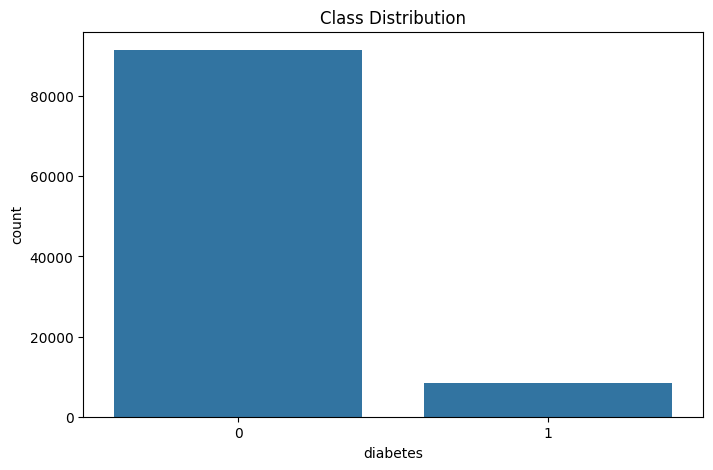

In [4]:
df = pd.read_csv("../../Datasets/diabetes_prediction_dataset.csv", encoding='latin1')
print(f"Dataset shape: {df.shape}")
print("\nData types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())

# Visualize class distribution
plt.figure(figsize=(8,5))
sns.countplot(x='diabetes', data=df)
plt.title('Class Distribution')
plt.show()

3. Handling missing values and replacing missing values with nan from numpy and replace with mean of all the other values

In [5]:
print(df.isnull().sum())
print(df.isna().sum())
dtale.show(df)

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


4. Encoding the categorical data

In [6]:
gender_mapping = {'Female': 0, 'Male': 1, 'Other': 2}
df['gender'] = df['gender'].map(gender_mapping)
dtale.show(df)

In [7]:
smoking_mapping = {'never': 0, 'not current': 1, 'current': 2, 
                  'No Info': 3, 'ever': 4, 'former': 5}
df['smoking_history'] = df['smoking_history'].map(smoking_mapping)
dtale.show(df)

5. Feature Engineering

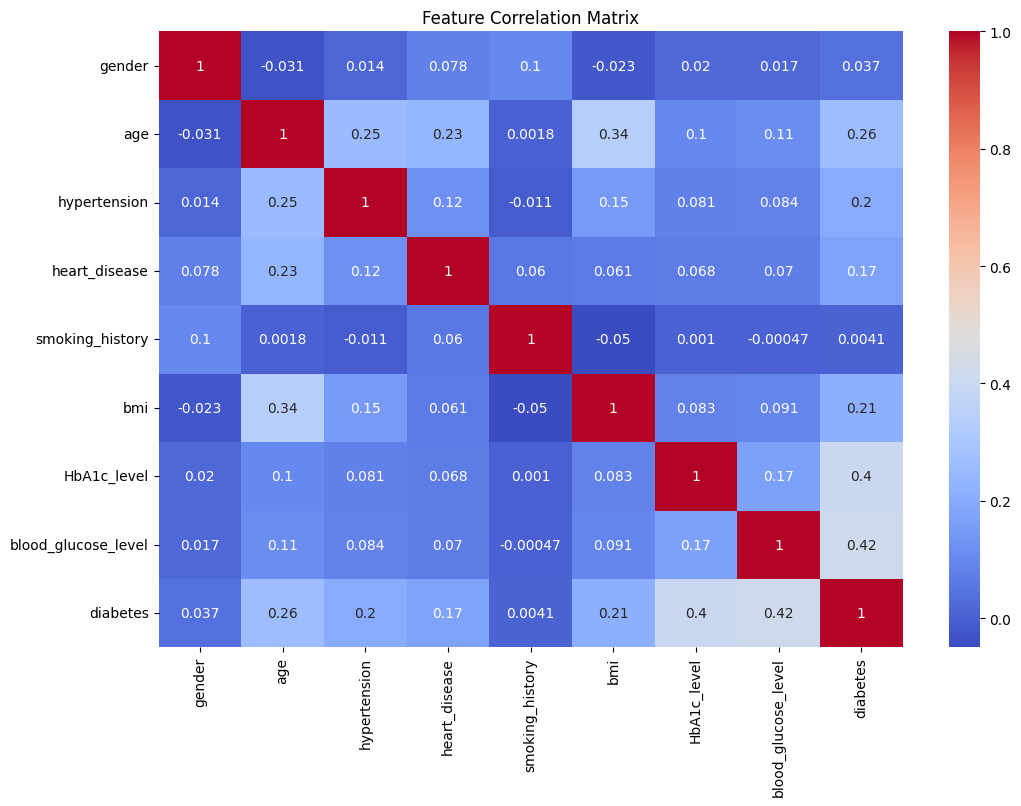

In [8]:
# Add feature correlation analysis
plt.figure(figsize=(12,8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

6. Split the attribites into dependent and independent attributes

In [9]:
X = df.iloc[:, :-1]  # DataFrame with original column names
Y = df.iloc[:, -1]   # Series with original name
dtale.show(X, ignore_duplicate=True)

ERROR	Thread(Thread-64 (process_request_thread)) dtale.utils:utils.py:handle_error()- Exception occurred while processing request: object of type 'NoneType' has no len()
 Traceback (most recent call last):
   File "C:\Users\Portia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\dtale\views.py", line 121, in _handle_exceptions
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
   File "C:\Users\Portia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\dtale\views.py", line 1603, in get_processes
    [_load_process(data_id) for data_id in global_state.keys()],
     ^^^^^^^^^^^^^^^^^^^^^^
   File "C:\Users\Portia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\dtale\views.py", line 1589, in _load_process
    columns=len(dtypes),
            ^^^^^^^^^^^


7. Splitting the dataset intro training set and test set

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

8. Train the Extreme Gradient Model

[0]	validation_0-logloss:0.28437
[10]	validation_0-logloss:0.24625
[20]	validation_0-logloss:0.21998
[30]	validation_0-logloss:0.20107
[40]	validation_0-logloss:0.18745
[50]	validation_0-logloss:0.17583
[60]	validation_0-logloss:0.16471
[70]	validation_0-logloss:0.15654
[80]	validation_0-logloss:0.14910
[90]	validation_0-logloss:0.14285
[100]	validation_0-logloss:0.13709
[110]	validation_0-logloss:0.13189
[120]	validation_0-logloss:0.12723
[130]	validation_0-logloss:0.12364
[140]	validation_0-logloss:0.11986
[150]	validation_0-logloss:0.11652
[160]	validation_0-logloss:0.11363
[170]	validation_0-logloss:0.11091
[180]	validation_0-logloss:0.10846
[190]	validation_0-logloss:0.10623
[200]	validation_0-logloss:0.10430
[210]	validation_0-logloss:0.10264
[220]	validation_0-logloss:0.10103
[230]	validation_0-logloss:0.09962
[240]	validation_0-logloss:0.09818
[250]	validation_0-logloss:0.09685
[260]	validation_0-logloss:0.09566
[270]	validation_0-logloss:0.09454
[280]	validation_0-logloss:0.09

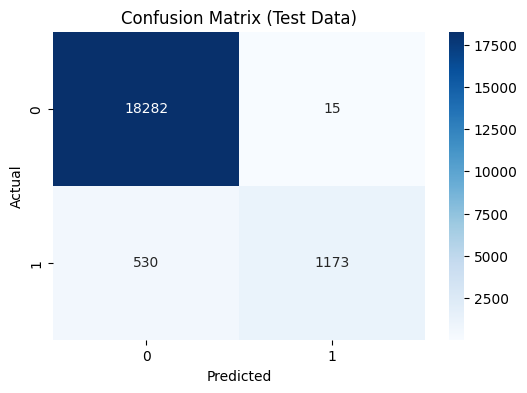

              precision    recall  f1-score      support
0              0.971826  0.999180  0.985314  18297.00000
1              0.987374  0.688784  0.811484   1703.00000
accuracy       0.972750  0.972750  0.972750      0.97275
macro avg      0.979600  0.843982  0.898399  20000.00000
weighted avg   0.973150  0.972750  0.970512  20000.00000


In [ ]:
xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.01,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'logloss',
    'random_state': 42
}
model = eXTremeGradientBoostingClassifier(**xgb_params)
model.fit(X_train, Y_train,
          eval_set=[(X_test, Y_test)],
          verbose=10)

# Display confusion matrix for the model on test data
y_pred_train = model.predict(X_test)
cm_train = confusion_matrix(Y_test, y_pred_train)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Data)')
plt.show()

# Display evaluation matrix (classification report)
report_train = classification_report(Y_test, y_pred_train, output_dict=True)
df_report_train = pd.DataFrame(report_train).transpose()
print(df_report_train)

9. Retraining the model using Resampled data

In [12]:
smote_enn = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, Y_train_res = smote_enn.fit_resample(X_train, Y_train)
print(pd.Series(Y_train_res).value_counts())

diabetes
0    73203
1    73203
Name: count, dtype: int64


In [13]:
model2 = eXTremeGradientBoostingClassifier(**xgb_params)
model2.fit(X_train_res, Y_train_res) 
Kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model, X_train_res, Y_train_res, cv=Kfold, scoring='accuracy')

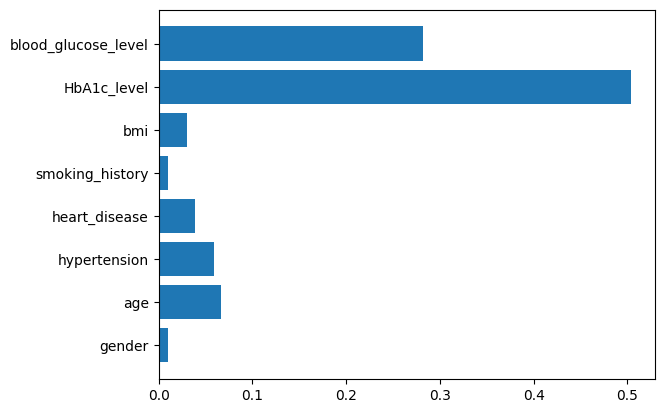

In [14]:
importances = model.feature_importances_
features = df.columns[:-1]
plt.barh(features, importances)
plt.show()

10. Evaluate the retrained model

              precision  recall  f1-score     support
0                0.9754  0.9857    0.9806  18297.0000
1                0.8272  0.7334    0.7775   1703.0000
accuracy         0.9643  0.9643    0.9643      0.9643
macro avg        0.9013  0.8596    0.8790  20000.0000
weighted avg     0.9628  0.9643    0.9633  20000.0000
ROC-AUC: 0.9764
Sensitivity: 0.7334
Specificity: 0.9857
Confusion Matrix:
[[18036   261]
 [  454  1249]]
Mean Accuracy:0.9636 (+/- 0.0028)


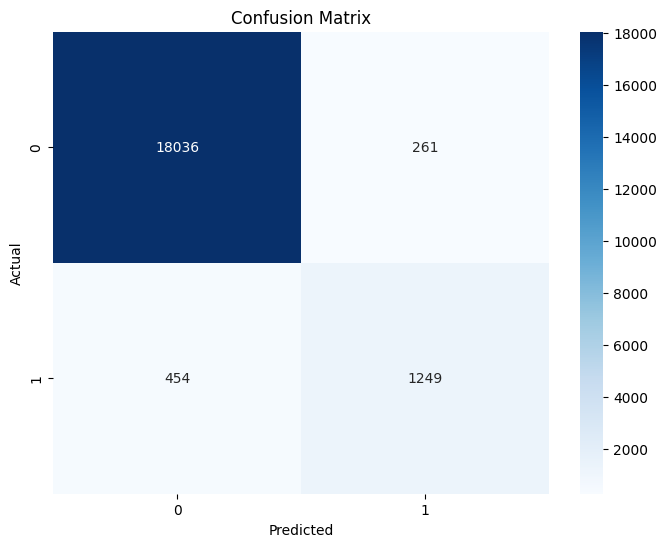

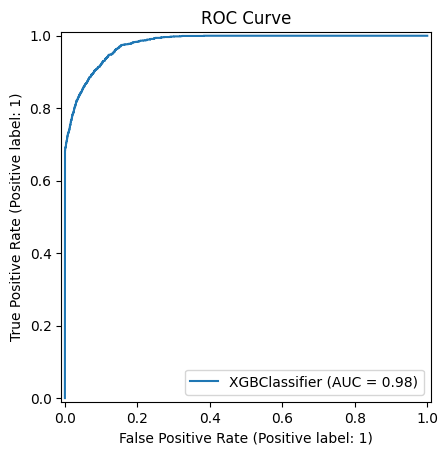

In [15]:
y_pred = model2.predict(X_test)
y_proba = model2.predict_proba(X_test)[:, 1]
sensitivity = recall_score(Y_test, y_pred, pos_label=1)
roc_auc = roc_auc_score(Y_test, y_proba)
cm = confusion_matrix(Y_test, y_pred)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)


report = classification_report(Y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

pd.set_option("display.precision", 4)
print(df_report)
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(Y_test, y_pred)}")
print(f"Mean Accuracy:{scores.mean():.4f} (+/- {scores.std():.4f})")# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
    
    # Plot ROC curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, X_test, Y_test)
plt.title('ROC Curve')
plt.show()

11.Feature Importance Visualization

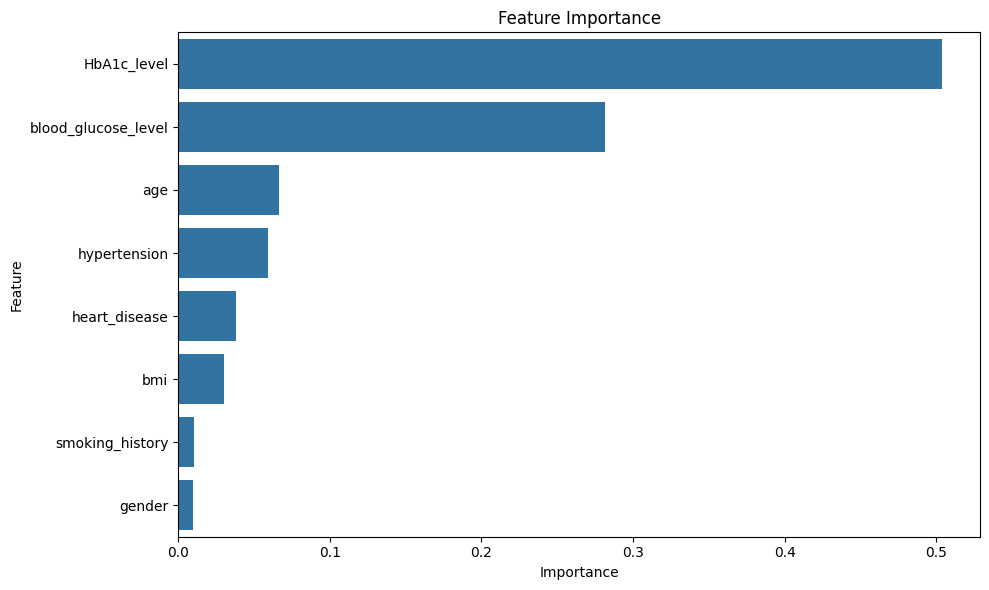

In [16]:
# Feature importance analysis
importance = model.feature_importances_
features = df.columns[:-1]

# Create DataFrame and sort
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

12. Apply Shapley Additive Technique to the data

In [19]:
#get the SHAP values
explainer = shap.Explainer(model2)
shap_values = explainer(X_train_res)
print(shap_values.shape)

(146406, 8)


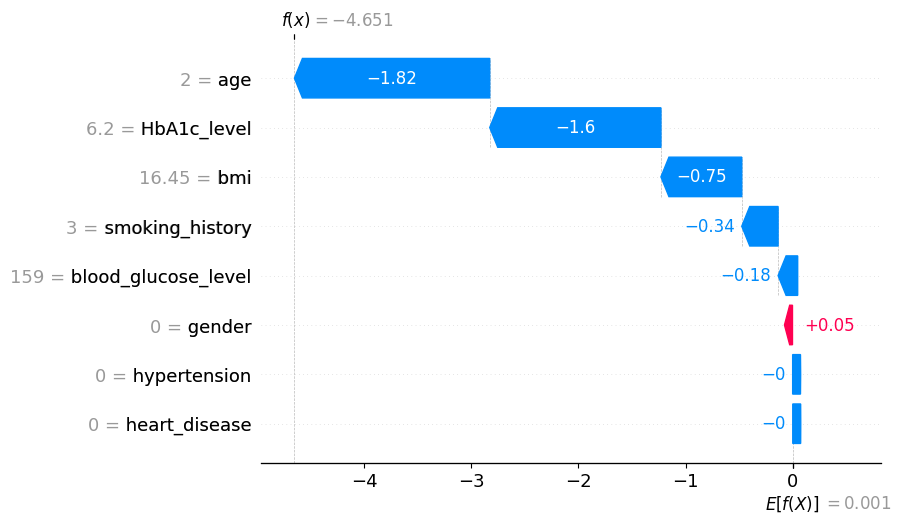

In [20]:
#Waterfall plot for the first observation
shap.plots.waterfall(shap_values[0])

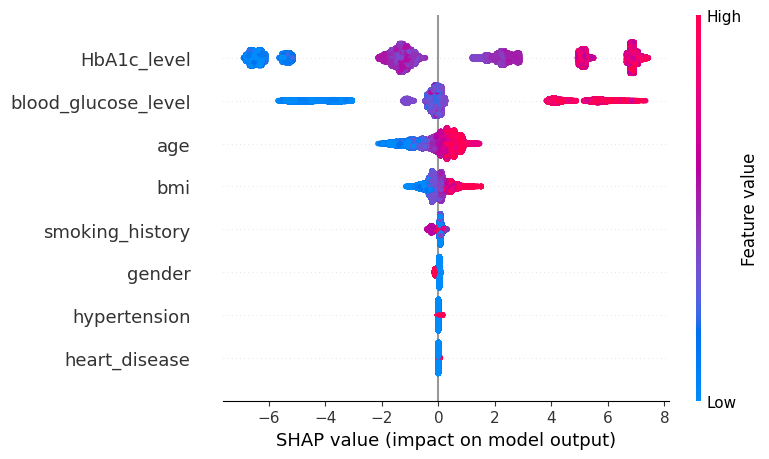

In [21]:
shap.summary_plot(shap_values, X_train_res)